<a href="https://colab.research.google.com/github/dowrave/Tutorial_tf.audio/blob/main/i_o_audio_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import tensorflow as tf
# !pip uninstall -q tensorflow-io
!pip install -q tensorflow-io==0.25.0 # 최신버전 에러
import tensorflow_io as tfio

audio = tfio.audio.AudioIOTensor('gs://cloud-samples-tests/speech/brooklyn.flac')

print(audio) # 28979, 1 : 샘플 28979(int16)와 채널 1개

<AudioIOTensor: shape=[28979     1], dtype=<dtype: 'int16'>, rate=16000>


In [13]:
# 내용 잘라내기
audio_slice = audio[100:]
audio_tensor = tf.squeeze(audio_slice, axis = [-1])
print(audio_tensor)

tf.Tensor([16 39 66 ... 56 81 83], shape=(28879,), dtype=int16)


In [14]:
# 오디오 재생
from IPython.display import Audio

Audio(audio_tensor.numpy(), rate = audio.rate.numpy())

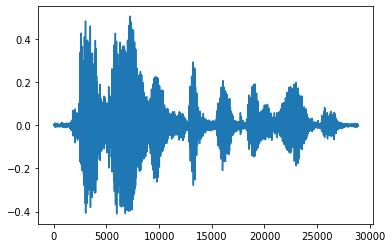

In [15]:
# 그래프로 오디오 클립 표시
import matplotlib.pyplot as plt

tensor = tf.cast(audio_tensor, tf.float32) / 32768.0 # 정규화는 비슷?
plt.figure()
plt.plot(tensor.numpy())

tf.Tensor([ 2398 23546], shape=(2,), dtype=int64)
tf.Tensor(2398, shape=(), dtype=int64) tf.Tensor(23546, shape=(), dtype=int64)


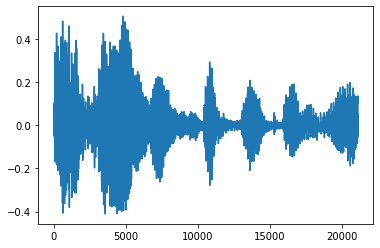

In [18]:
# 노이즈 제거 : tfio.audio.trim
position = tfio.audio.trim(tensor, axis = 0, epsilon = 0.1)
print(position)

start = position[0]
stop = position[1]

print(start, stop)

processed = tensor[start:stop]

plt.figure()
plt.plot(processed.numpy())

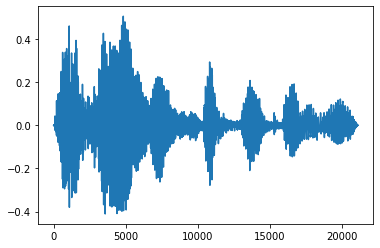

In [22]:
# 페이드인, 페이드 아웃
  # 오디오 신호를 늘이거나 줄이는 기술

fade  = tfio.audio.fade(processed, fade_in = 1000, fade_out = 2000, mode = 'logarithmic')

plt.figure()
plt.plot(fade.numpy())

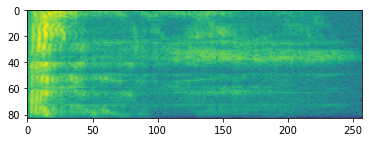

In [24]:
# 스펙트럼 사진(스펙트로그램)
# 고급 오디오 처리는 시간 경과에 따른 주파수 변화에 대응됨

# 스펙트로그램으로 변환
spectrogram = tfio.audio.spectrogram(
    fade, nfft = 512, window = 512, stride = 256
)

plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())

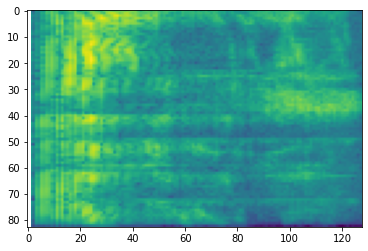

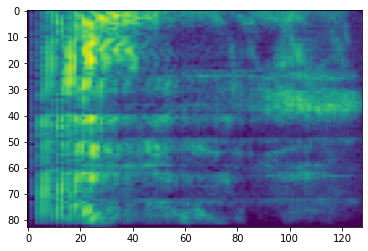

In [25]:
# 다른 스케일로의 추가 변환
mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate = 16000, mels = 128, fmin = 0, fmax = 8000
)

plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())

# db scale의 mel-Spectrogram으로 변환
dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db = 80
)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

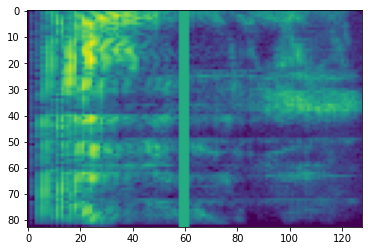

In [26]:
# 주파수 마스킹 : [f0, f0 + f)가 마스킹됨
freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param = 10)

plt.figure()
plt.imshow(freq_mask.numpy())

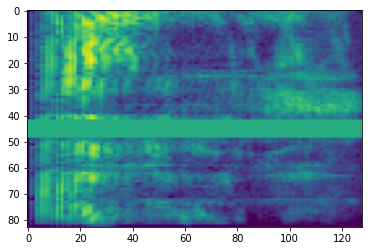

In [28]:
# 시간 마스킹
# Time masking
time_mask = tfio.audio.time_mask(dbscale_mel_spectrogram, param=10)

plt.figure()
plt.imshow(time_mask.numpy())